In [1]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(46)
torch.set_default_device(device)

device

'cuda'

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root="data",
    train=True,
    transform=ToTensor(),
    download=True,
)
test_data = datasets.MNIST(root="data", train=False, transform=ToTensor())
X_train_not_normalized = train_data.data.float().to(device=device)
y_train = train_data.targets.to(device=device)
X_test_not_normalized = test_data.data.float().to(device=device)
y_test = test_data.targets.to(device=device)

X_train = (X_train_not_normalized - X_train_not_normalized.min()) / (
    X_train_not_normalized.max() - X_train_not_normalized.min()
)
X_test = (X_test_not_normalized - X_test_not_normalized.min()) / (
    X_test_not_normalized.max() - X_test_not_normalized.min()
)

In [3]:
class Teacher(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.activation_function = nn.ReLU()

        self.flatten = nn.Flatten()

        self.layer_one = nn.Linear(
            in_features=784, out_features=1024, dtype=torch.float
        )
        self.layer_two = nn.Linear(
            in_features=1024, out_features=512, dtype=torch.float
        )
        self.layer_three = nn.Linear(
            in_features=512, out_features=10, dtype=torch.float
        )

    def forward(self, x: torch.Tensor):
        out = self.flatten(x)
        out = self.activation_function(self.layer_one(out))
        out = self.activation_function(self.layer_two(out))
        out = self.layer_three(out)
        return out


class Student(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.activation_function = nn.ReLU()

        self.flatten = nn.Flatten()

        self.layer_one = nn.Linear(in_features=784, out_features=128, dtype=torch.float)
        self.layer_two = nn.Linear(in_features=128, out_features=64, dtype=torch.float)
        self.layer_three = nn.Linear(in_features=64, out_features=10, dtype=torch.float)

    def forward(self, x: torch.Tensor):
        out = self.flatten(x)
        out = self.activation_function(self.layer_one(out))
        out = self.activation_function(self.layer_two(out))
        out = self.layer_three(out)
        return out


teacher_model = Teacher()
student_model = Student()

teacher_model.load_state_dict(torch.load("./TeacherModel.pth"))

teacher_y_train_logits = teacher_model(X_train).float().detach()
teacher_y_train = torch.argmax(teacher_y_train_logits, dim=1).float().detach()
teacher_y_test_logits = teacher_model(X_test).float().detach()
teacher_y_test = torch.argmax(teacher_y_test_logits, dim=1).float().detach()

In [4]:
import math
import matplotlib.pyplot as plt
import time

EPOCHS = 10
ALPHA = 0.01
BATCH_SIZE = 32
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(student_model.parameters(), lr=ALPHA)


def printLogs(epoch, epochs, loss, accuracy, test_accuracy, test_loss):
    local_time = time.localtime()
    print(
        f"{local_time.tm_hour}:{local_time.tm_min}:{local_time.tm_sec}: Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%  | Test loss: {test_loss:.5f}"
    )


general_loss = []  # to be shown after epochs
general_test_loss = []  # to be shown after epochs
general_accuracy = []  # to be shown after epochs
general_test_accuracy = []  # to be shown after epochs

batch_iterations = math.ceil(X_train.shape[0] / BATCH_SIZE)

for epoch in range(EPOCHS):
    accuracies = 0
    test_accuracies = 0
    test_losses = 0
    losses = 0
    for batch_index in range(batch_iterations):
        student_model.train()
        # start_time = time.time()

        X_train_batch = X_train[
            batch_index * BATCH_SIZE : batch_index * BATCH_SIZE + BATCH_SIZE
        ]
        teacher_y_train_batch = teacher_y_train[
            batch_index * BATCH_SIZE : batch_index * BATCH_SIZE + BATCH_SIZE
        ]

        student_y_logits = student_model(X_train_batch)

        y_pred = torch.argmax(student_y_logits, dim=1)

        accuracy = (
            torch.eq(teacher_y_train_batch, y_pred).count_nonzero()
            / teacher_y_train_batch.__len__()
            * 100
        )

        accuracies += accuracy

        loss = loss_function(
            student_y_logits,
            teacher_y_train_logits[
                batch_index * BATCH_SIZE : batch_index * BATCH_SIZE + BATCH_SIZE
            ],
        )

        losses += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        student_y_logits.detach_()
        y_pred.detach_()

        student_model.eval()

        with torch.inference_mode():
            # start_time = time.time()
            student_y_test_logits = student_model(X_test)
            y_test_pred = torch.argmax(student_y_test_logits, dim=1)

            test_loss = loss_function(
                student_y_test_logits,
                teacher_y_test_logits,
            )
            test_accuracy = (
                torch.eq(teacher_y_test, y_test_pred).count_nonzero()
                / teacher_y_test.__len__()
                * 100
            )

            test_accuracies += test_accuracy
            test_losses += test_loss
            # end_time = time.time()
            # print(f"Test duration :{end_time-start_time}")

    average_accuracy = accuracies / batch_iterations
    average_test_accuracy = test_accuracies / batch_iterations

    general_loss.append(losses)
    general_test_loss.append(test_losses)
    general_test_accuracy.append(average_test_accuracy.item())
    general_accuracy.append(average_accuracy.item())
    printLogs(
        epoch,
        EPOCHS,
        losses,
        average_accuracy,
        average_test_accuracy,
        test_losses,
    )

12:51:37: Epoch: 0 | Loss: 7631.27572, Accuracy: 84.31%, Test Accuracy: 84.73%  | Test loss: 7759.97852
12:51:42: Epoch: 1 | Loss: 873.71777, Accuracy: 96.82%, Test Accuracy: 97.34%  | Test loss: 864.58008
12:51:46: Epoch: 2 | Loss: 495.18374, Accuracy: 97.83%, Test Accuracy: 98.26%  | Test loss: 494.96655
12:51:51: Epoch: 3 | Loss: 371.97757, Accuracy: 98.20%, Test Accuracy: 98.59%  | Test loss: 376.49808
12:51:55: Epoch: 4 | Loss: 319.89183, Accuracy: 98.39%, Test Accuracy: 98.75%  | Test loss: 325.31287
12:52:0: Epoch: 5 | Loss: 280.65440, Accuracy: 98.54%, Test Accuracy: 98.86%  | Test loss: 288.79462
12:52:5: Epoch: 6 | Loss: 254.42595, Accuracy: 98.65%, Test Accuracy: 98.92%  | Test loss: 264.18146
12:52:9: Epoch: 7 | Loss: 238.32489, Accuracy: 98.74%, Test Accuracy: 98.96%  | Test loss: 248.81517
12:52:14: Epoch: 8 | Loss: 222.60704, Accuracy: 98.81%, Test Accuracy: 98.99%  | Test loss: 234.20139
12:52:19: Epoch: 9 | Loss: 210.17735, Accuracy: 98.86%, Test Accuracy: 99.02%  | Te

Misclassification (to Teacher ) in 10000 pictures: 104 (98.95999908447266 Accuracy)
Misclassification (to Real Data) in 10000 pictures: 309 (96.91000366210938 Accuracy)


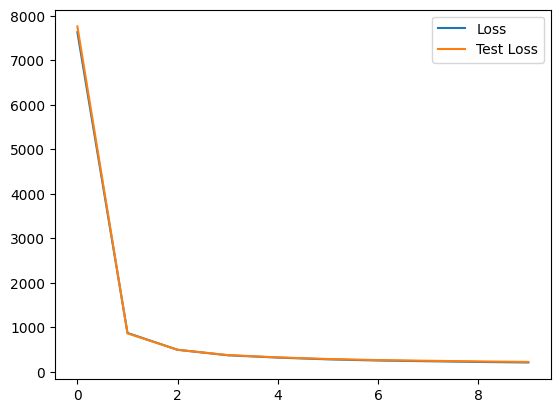

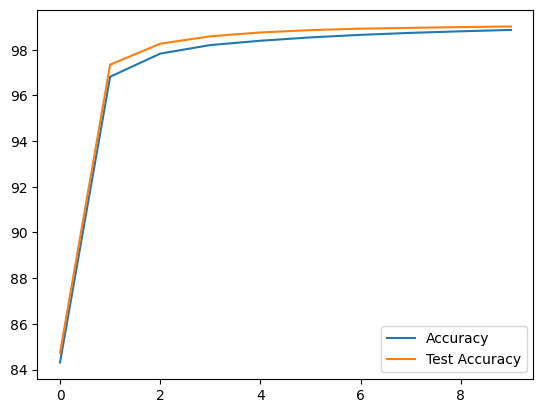

In [5]:
y_pred = torch.argmax(student_model(X_test), dim=1)
misclassifications_to_teacher_model = (y_pred != teacher_y_test).count_nonzero()
misclassifications_to_real_y_test = (y_pred != y_test).count_nonzero()
print(
    f"Misclassification (to Teacher ) in {teacher_y_test.__len__()} pictures: {misclassifications_to_teacher_model} ({(teacher_y_test.__len__()-misclassifications_to_teacher_model)/teacher_y_test.__len__()*100} Accuracy)"
)
print(
    f"Misclassification (to Real Data) in {y_test.__len__()} pictures: {misclassifications_to_real_y_test} ({(y_test.__len__()-misclassifications_to_real_y_test)/y_test.__len__()*100} Accuracy)"
)
plt.plot(torch.tensor(general_loss).cpu(), label="Loss")
plt.plot(torch.tensor(general_test_loss).cpu(), label="Test Loss")
plt.legend()
plt.show()
plt.plot(torch.tensor(general_accuracy).cpu(), label="Accuracy")
plt.plot(torch.tensor(general_test_accuracy).cpu(), label="Test Accuracy")
plt.legend()
plt.show()